##  AMA KAMA

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
RANDOM_SEED = 2750
np.random.seed(RANDOM_SEED)


In [2]:
import sys
from pathlib import Path

sys.path.append("systrade")

In [3]:
config_base_path = "systrade"

In [4]:
from backtester.backtest_engine import *
from backtester.data_loader import *
from backtester.visualizations import *
from backtester.utils import *
from backtester.reports import *

In [5]:
from strategies.strategy_ama_kama import * 
from visuals.plot_ama_kama_signals import *

In [6]:
# dji_components = ["MMM", "AXP", "AMGN", "AMZN", "AAPL", "BA", "CAT", "CVX", "CSCO", "KO", "DIS", "GS", "HD", "HON", "IBM", "JNJ", "JPM", "MCD", "MRK", "MSFT", "NKE", "NVDA", "PG", "CRM", "SHW", "TRV", "UNH", "VZ", "V", "WMT"]
dji_halfweight = ["GS", "MSFT", "HD", "V", "SHW", "CAT", "MCD", "UNH", "AXP"] #account for 50% of weighting

In [7]:
# Download market data
tickers = dji_halfweight

# Walk-Forward Analysis and Sensitivity Analysis

In [8]:
from backtester.walkforward_cv import *

In [9]:
set_random_seed(RANDOM_SEED)
data_dict = download_multiple(tickers,start_date='2017-04-01', end_date='2023-01-01')



  GS...  1448 bars
  MSFT...  1448 bars
  HD...  1448 bars
  V...  1448 bars
  SHW...  1448 bars
  CAT...  1448 bars
  MCD...  1448 bars
  UNH...  1448 bars
  AXP...  1448 bars
Successfully downloaded 9/9 tickers



In [10]:
trade_config = TradeConfig(
    initial_capital=300_000,
    position_size_pct=0.05,
    commission_pct=0.001,
    slippage_pct=0.0005,
    slippage_fixed=0.0,
    max_trade_size=30_000,        
    min_trade_size=10_000
)

wf_config = create_wf_config(
    training_days=252*2,
    testing_days=21*9,
    holdout_days=21*6,
    min_trades=30,
    n_trials=150,
    n_startup_trials = 50,
    n_jobs=-1,
    timeout=3600,
    random_seed=2570
)


In [11]:
def get_ama_kama_param_space() -> Dict[str, Tuple]:
    return {
        'ama_period': ('int', 5, 20),
        'ama_fast': ('int', 2, 5),
        'ama_slow': ('int', 20, 40),
        'kama_er_period': ('int', 5, 20),
        'kama_fast': ('int', 2, 5),
        'kama_slow': ('int', 20, 40),
        'kama_period': ('int', 10, 30),
        'rsi_period': ('int', 7, 21),
        'rsi_entry_max': ('int', 25, 45),
        'rsi_exit_min': ('int', 55, 75),
        'atr_period': ('int', 10, 20),
        'atr_multiplier': ('float', 1.5, 3.0)
    }

[I 2026-01-15 11:15:44,681] A new study created in memory with name: AMAKAMAStrategy_global_cv


Global Walk-Forward: 3 windows from 2017-04-03 to 2022-12-30

Running Global Optimization on 3 windows...
Global Optimization Complete. Best Score: 0.9268
{'ama_period': 14, 'ama_fast': 4, 'ama_slow': 40, 'kama_er_period': 9, 'kama_fast': 2, 'kama_slow': 30, 'kama_period': 28, 'rsi_period': 16, 'rsi_entry_max': 43, 'rsi_exit_min': 74, 'atr_period': 19, 'atr_multiplier': 1.8957813856544719}

--- Degradation Analysis ---
Avg Sharpe Degradation: 35.66% (Lower is better)
  < 10%: Very Robust
  > 50%: High Overfitting

--- Parameter Stability (Cluster Analysis) ---
         parameter     cv  range_ratio assessment
1         ama_fast  0.000        0.000  Excellent
4        kama_fast  0.000        0.000  Excellent
2         ama_slow  0.017        0.050  Excellent
9     rsi_exit_min  0.022        0.068  Excellent
8    rsi_entry_max  0.034        0.140  Excellent
10      atr_period  0.043        0.105  Excellent
3   kama_er_period  0.048        0.111  Excellent
5        kama_slow  0.038        

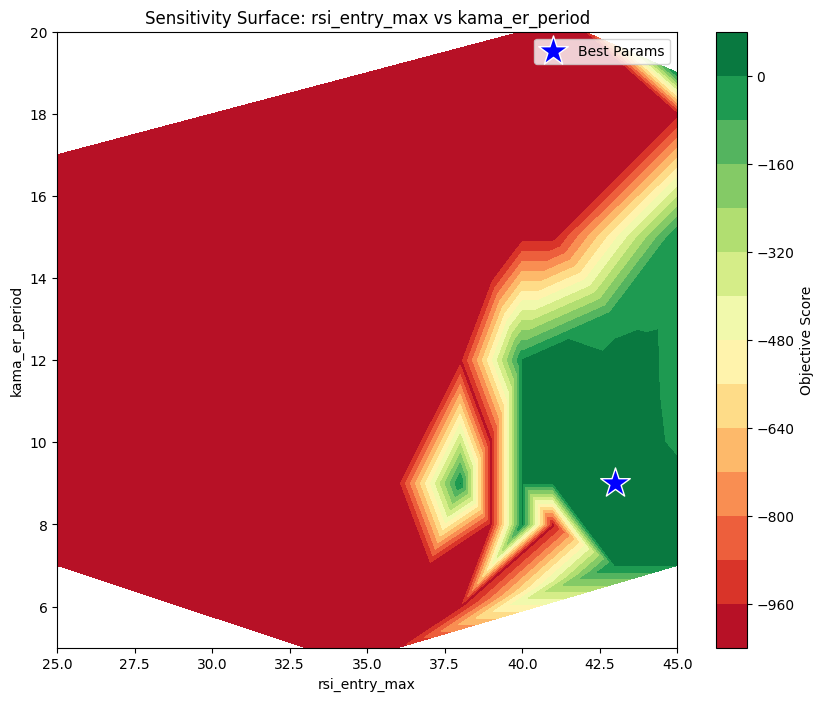

Results saved to wf_method2_results


In [12]:

param_space = get_ama_kama_param_space()


results_df, sensitivity_df = run_walkforward(
    data_dict=data_dict,
    param_space=param_space,
    strategy_class=AMAKAMAStrategy,
    strategy_name="AMAKAMAStrategy",
    trade_config=trade_config,
    wf_config=wf_config,
    objective_weights=(0.35, 0.65),  # 35% win rate, 65% Sharpe
    verbose=True
)



# Backtest on Holdout Dataset 

In [13]:
start_date = '2023-01-01'
raw_data = download_multiple(tickers, start_date)


  GS...  761 bars
  MSFT...  761 bars
  HD...  761 bars
  V...  761 bars
  SHW...  761 bars
  CAT...  761 bars
  MCD...  761 bars
  UNH...  761 bars
  AXP...  761 bars
Successfully downloaded 9/9 tickers



In [14]:
# Load configurations
strategy_config, trade_config, full_config = load_configs(
    f'{config_base_path}/configs/ama_kama_strategy.yaml',
    f'{config_base_path}/configs/default_settings.yaml'
)

In [15]:
strategy_config

StrategyConfig(name='AMA_KAMA', parameters={'ama_period': 10, 'ama_fast': 2, 'ama_slow': 30, 'kama_er_period': 10, 'kama_fast': 2, 'kama_slow': 30, 'kama_period': 20, 'rsi_period': 14, 'rsi_entry_max': 35, 'rsi_exit_min': 65, 'atr_period': 14, 'atr_multiplier': 2.0})

In [16]:
trade_config

TradeConfig(initial_capital=100000, commission_pct=0.001, slippage_pct=0.0005, slippage_fixed=0.01, position_size_pct=0.95, max_trade_size=50000, min_trade_size=100)

In [17]:
trade_config.initial_capital = 300_000
trade_config.max_trade_size = 30_000
trade_config.min_trade_size = 10_000

In [18]:
trade_config

TradeConfig(initial_capital=300000, commission_pct=0.001, slippage_pct=0.0005, slippage_fixed=0.01, position_size_pct=0.95, max_trade_size=30000, min_trade_size=10000)

In [19]:
strategy_config.parameters =  {'ama_period': 14, 'ama_fast': 4, 'ama_slow': 40, 'kama_er_period': 9, 'kama_fast': 2, 'kama_slow': 30, 'kama_period': 28, 'rsi_period': 16, 'rsi_entry_max': 43, 'rsi_exit_min': 74, 'atr_period': 19, 'atr_multiplier': 1.8957813856544719}


In [20]:
aligned_data = align_data(raw_data)

print(f" Downloaded data for {len(tickers)} tickers")
if len(aligned_data) > 0:
    first_ticker = list(aligned_data.keys())[0]
    date_range = f"{aligned_data[first_ticker].index[0]} to {aligned_data[first_ticker].index[-1]}"
    print(f"   Date range: {date_range}")
    print(f"   Total bars per ticker: {len(aligned_data[first_ticker])}")

 Downloaded data for 9 tickers
   Date range: 2023-01-03 00:00:00 to 2026-01-14 00:00:00
   Total bars per ticker: 761


In [21]:
# Initialize strategy

strategy = AMAKAMAStrategy(strategy_config)

# Validate configuration
if not strategy.validate_config():
    print(" Invalid configuration!")


 Invalid configuration!


In [22]:
# Run backtest
print("\n Running backtest...")
engine = BacktestEngine(strategy, trade_config)
results = engine.run(aligned_data)

# Print results
print_performance_summary(results.metrics)



 Running backtest...

PERFORMANCE SUMMARY

*** RETURNS ***
  Initial Capital:    $  300,000.00
  Final Value:        $  363,207.26
  Total P&L:          $   63,207.26
  Total Return:              21.07%

*** RISK METRICS ***
  Sharpe Ratio:               1.27
  Sortino Ratio:              1.58
  Max Drawdown:              -4.92%
  Calmar Ratio:               4.28
  Annual Volatility:          5.07%

*** TRADE STATISTICS ***
  Total Trades:                 81
  Win Rate:                  65.43%
  Profit Factor:              2.87
  Expectancy:         $      807.79
  Best Trade:         $     7455.42
  Worst Trade:        $    -7558.69
  Average Trade:      $      807.79

*** COSTS ***
  Total Commission:   $        0.00
  Total Slippage:     $        0.00
  Total Costs:        $        0.00




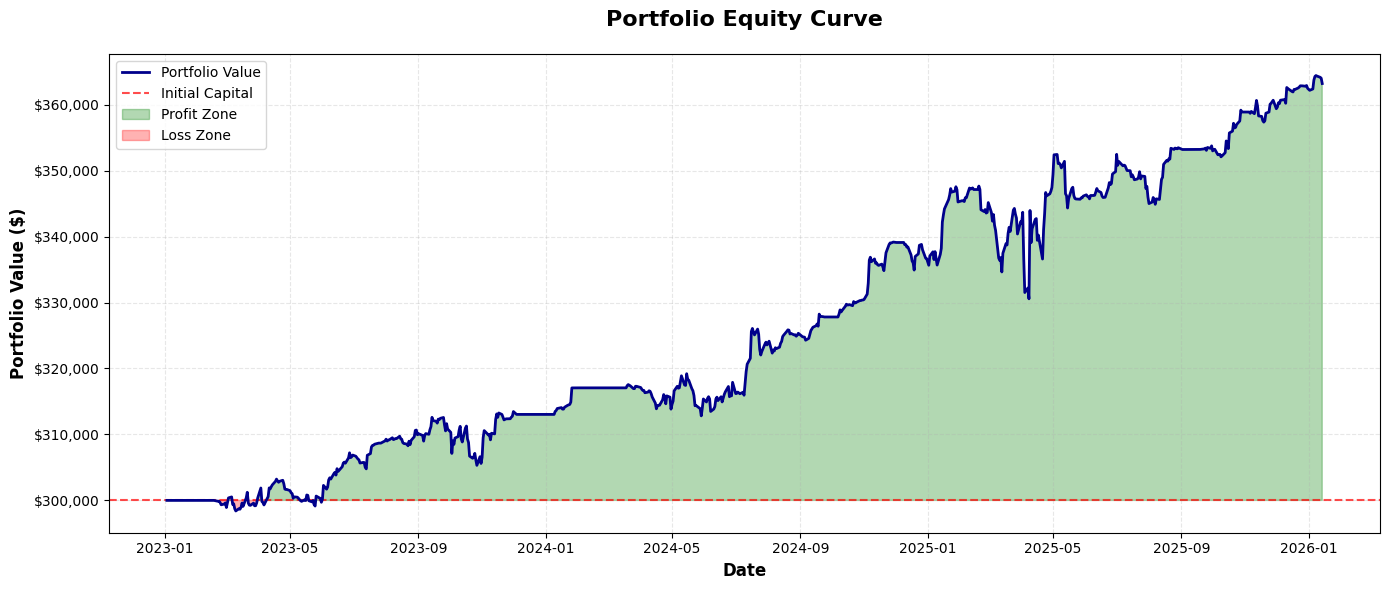

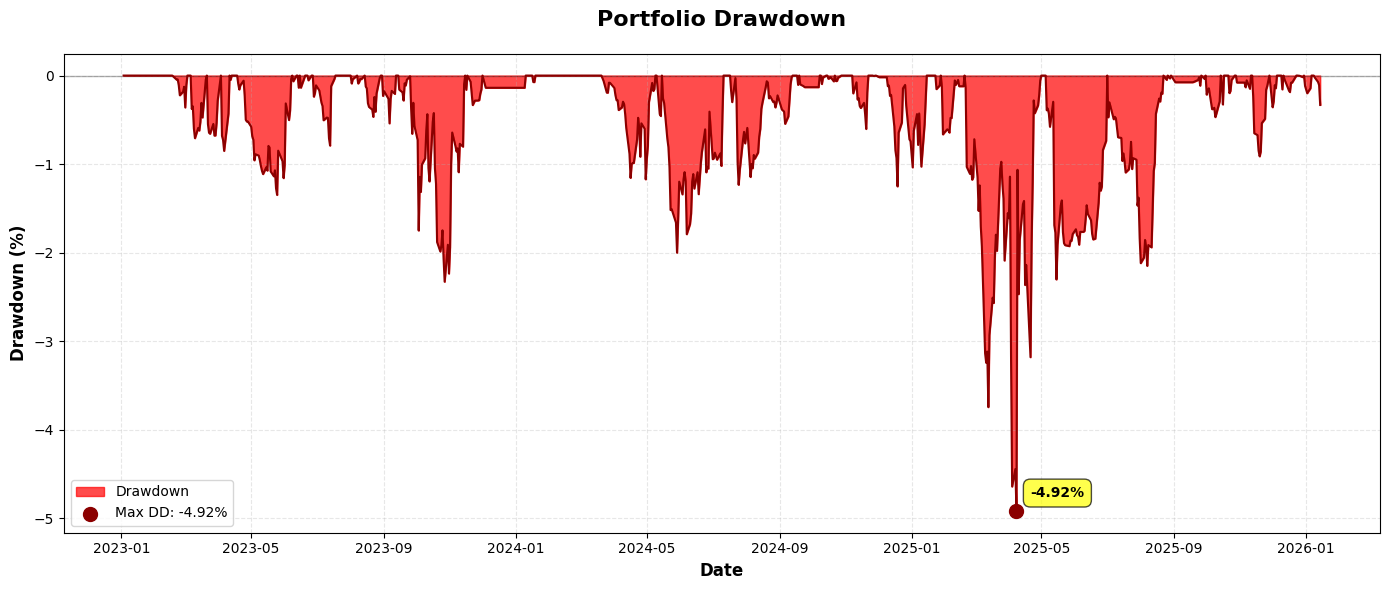

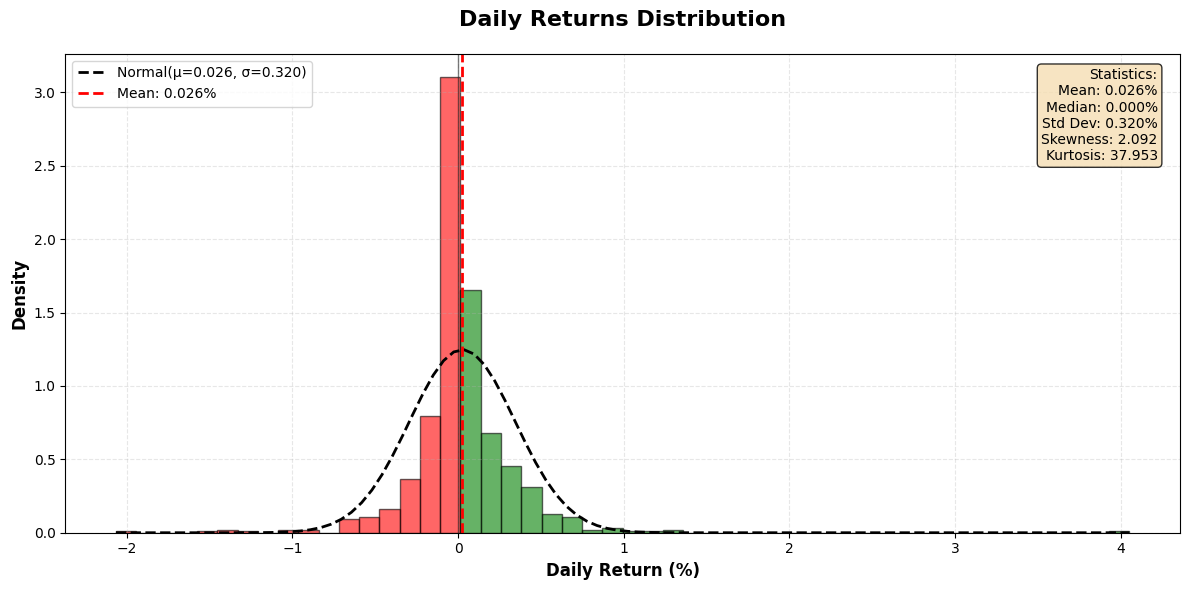

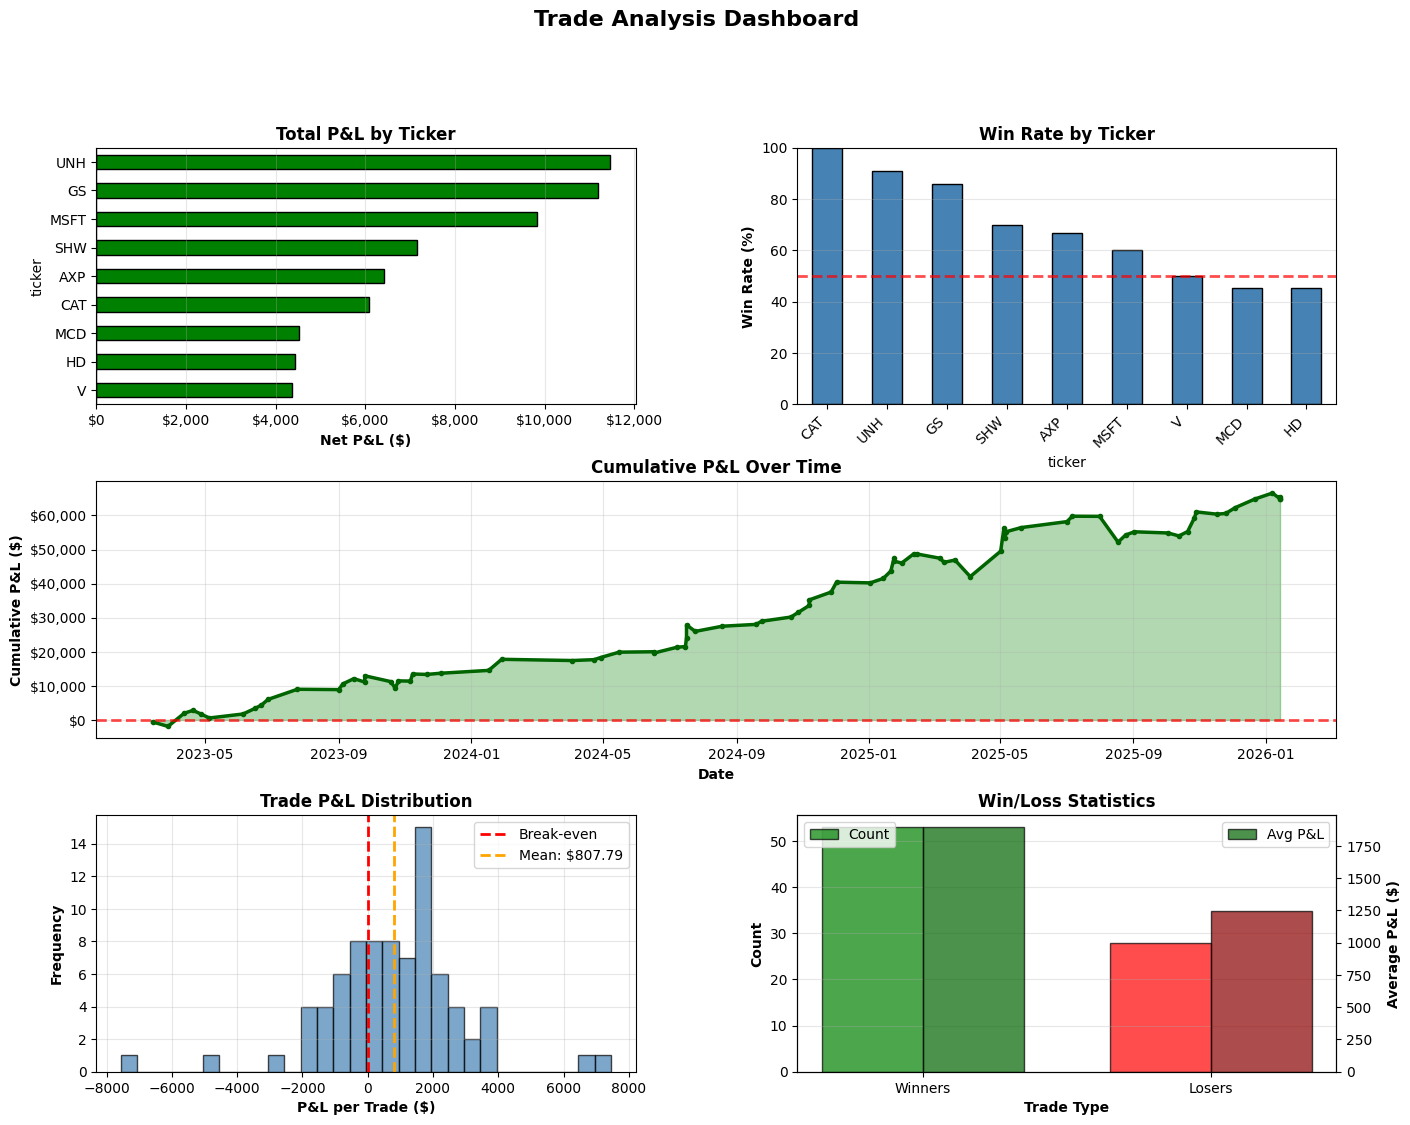

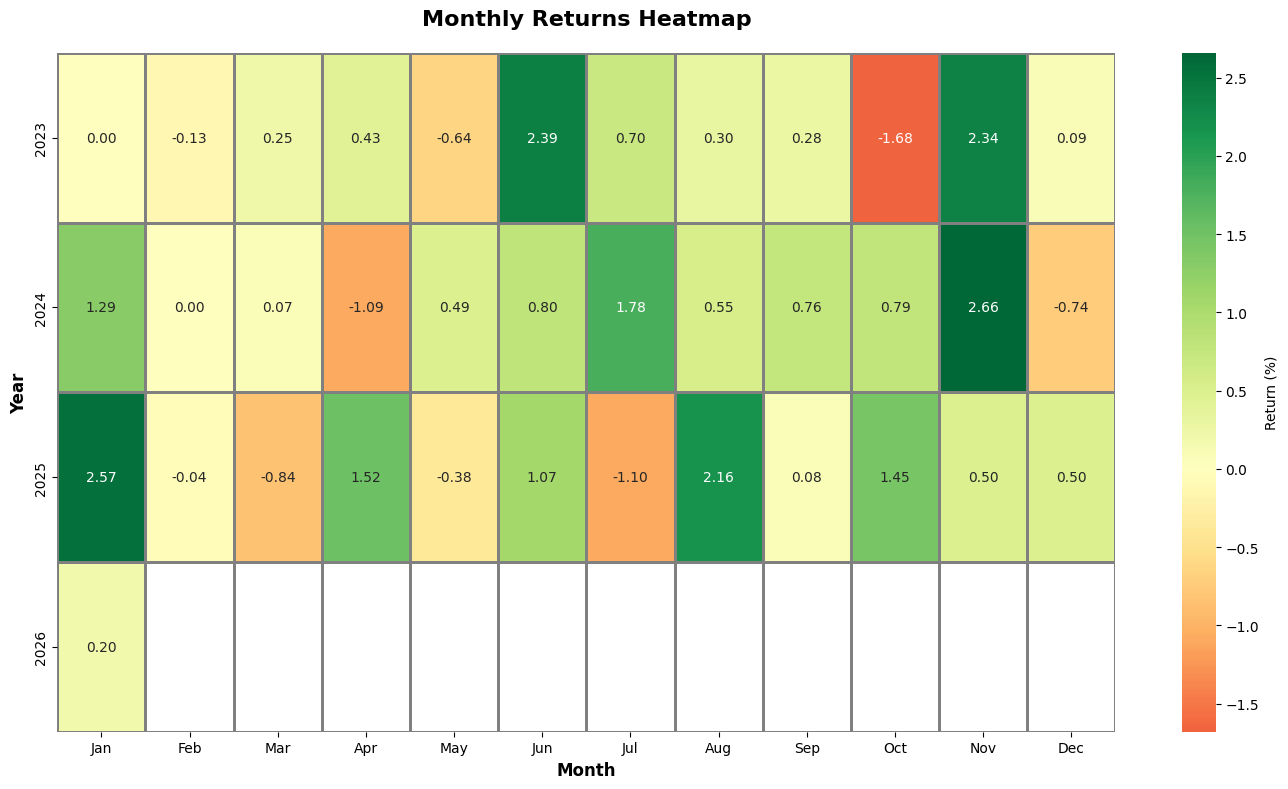

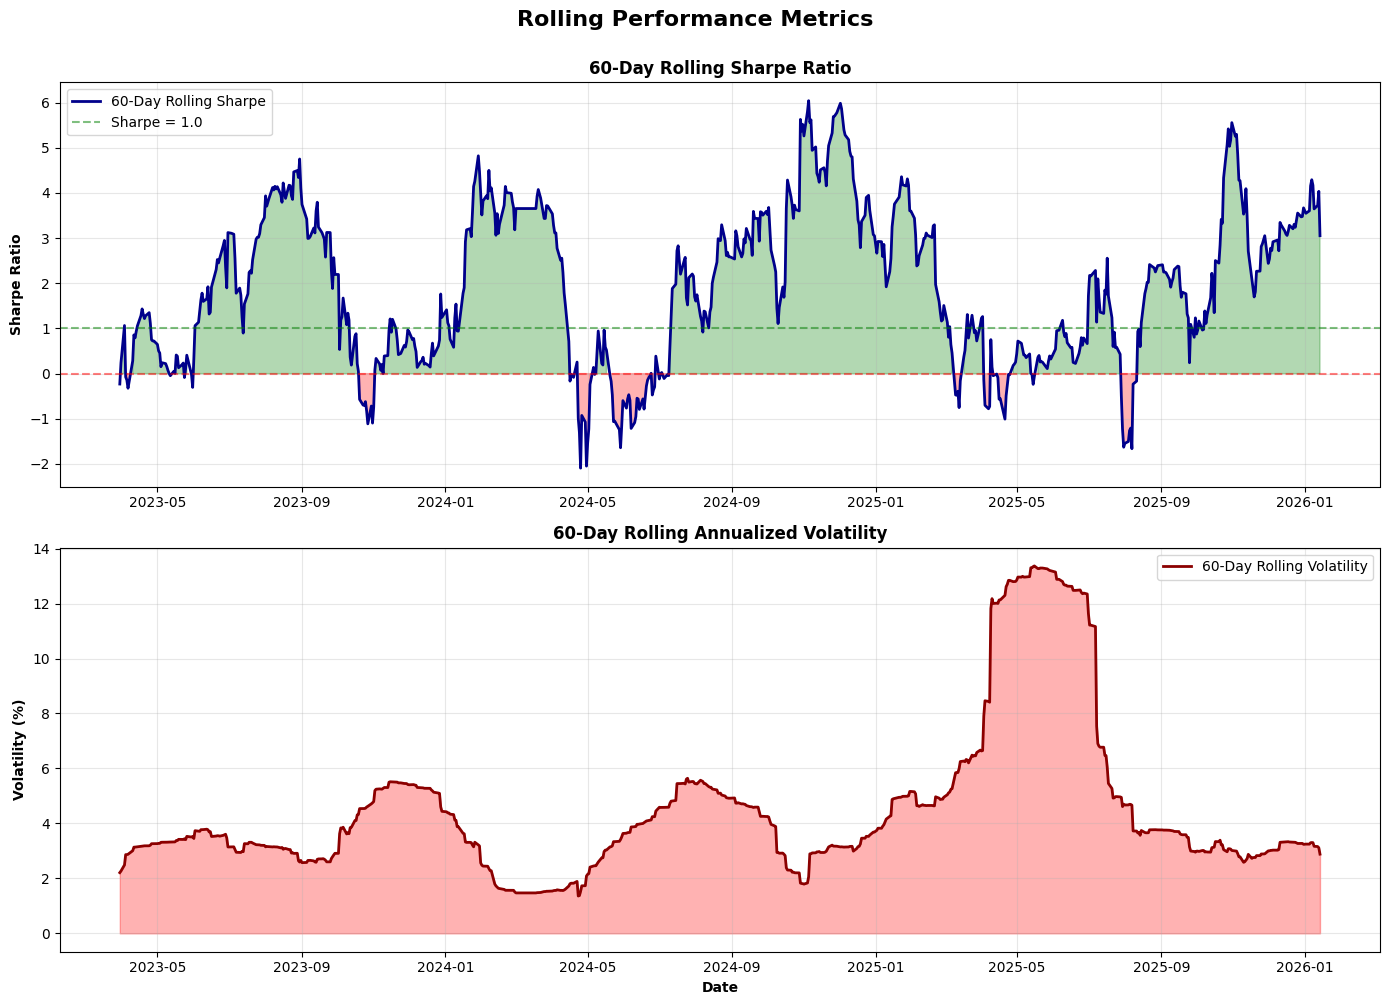

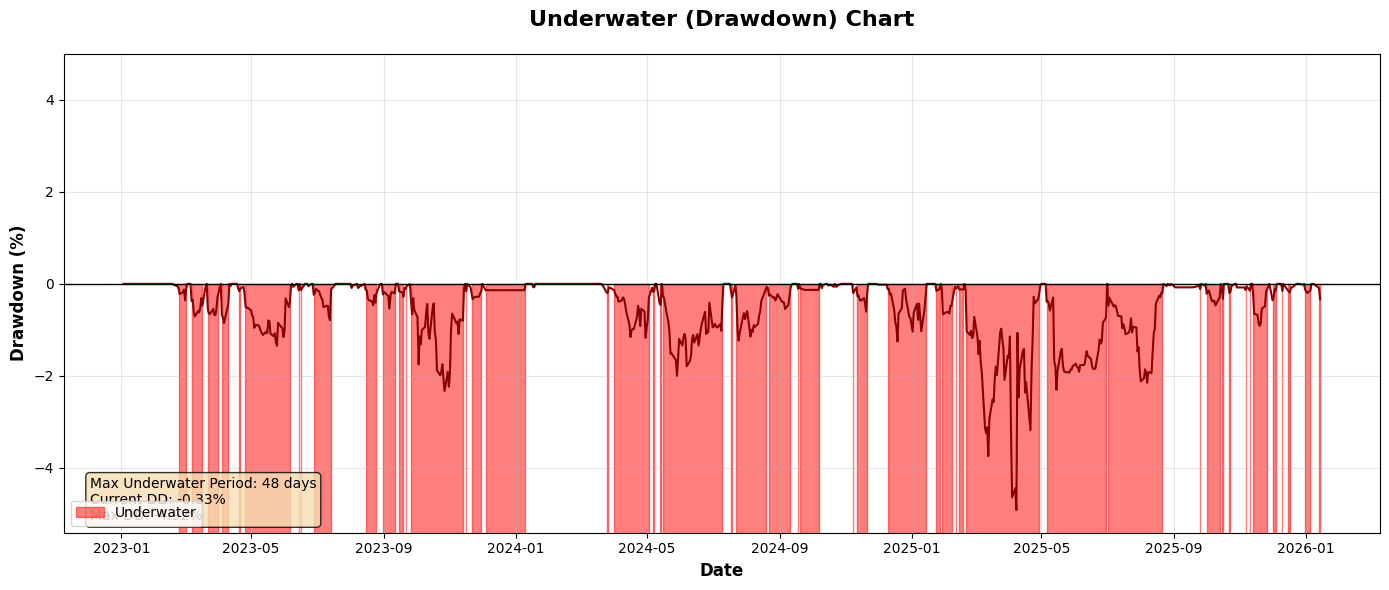

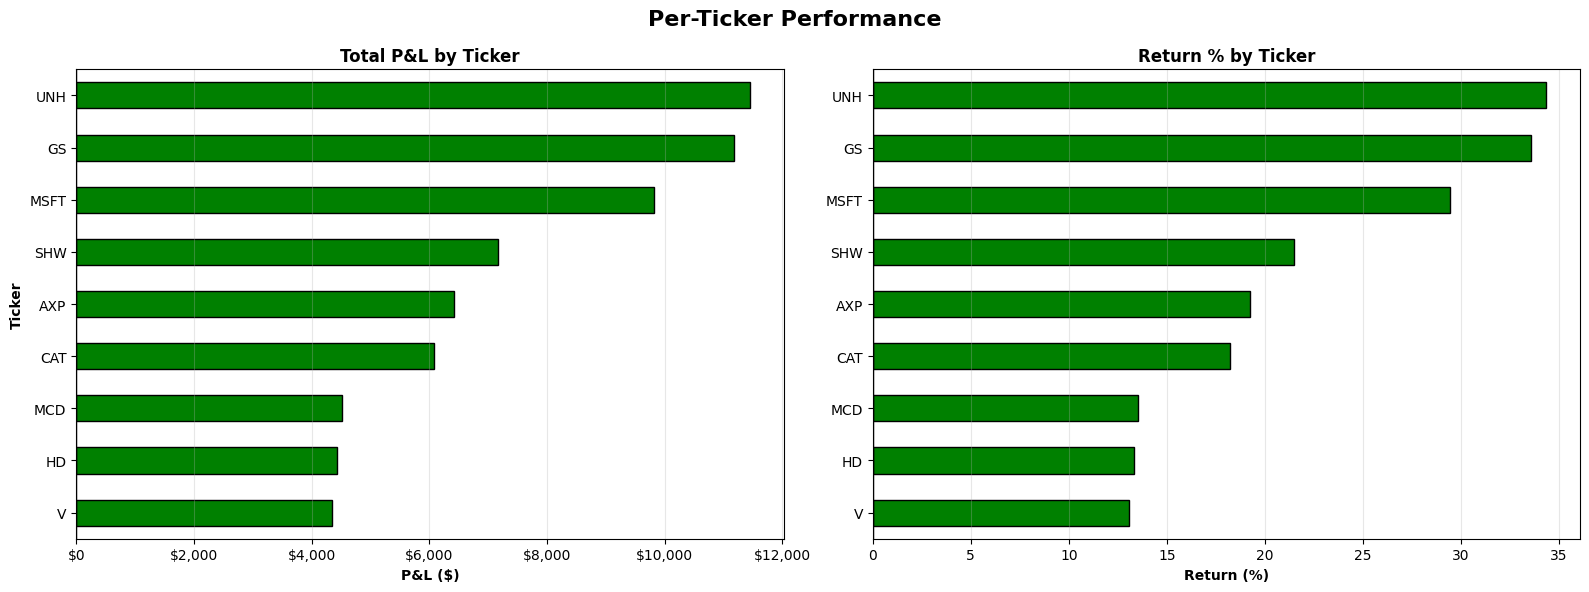

In [23]:
plot_performance_dashboard(results.portfolio_state, trade_config.initial_capital)

In [24]:
# Prepare data with indicators (SAVE THIS!)
prepared_data = {}
for ticker, df in aligned_data.items():
    prepared = strategy.prepare_data(df)
    prepared['ticker'] = ticker
    prepared_data[ticker] = prepared


AMA-KAMA STRATEGY VISUALIZATION FOR UNH
Period: 2023-01-01 to 2025-12-31


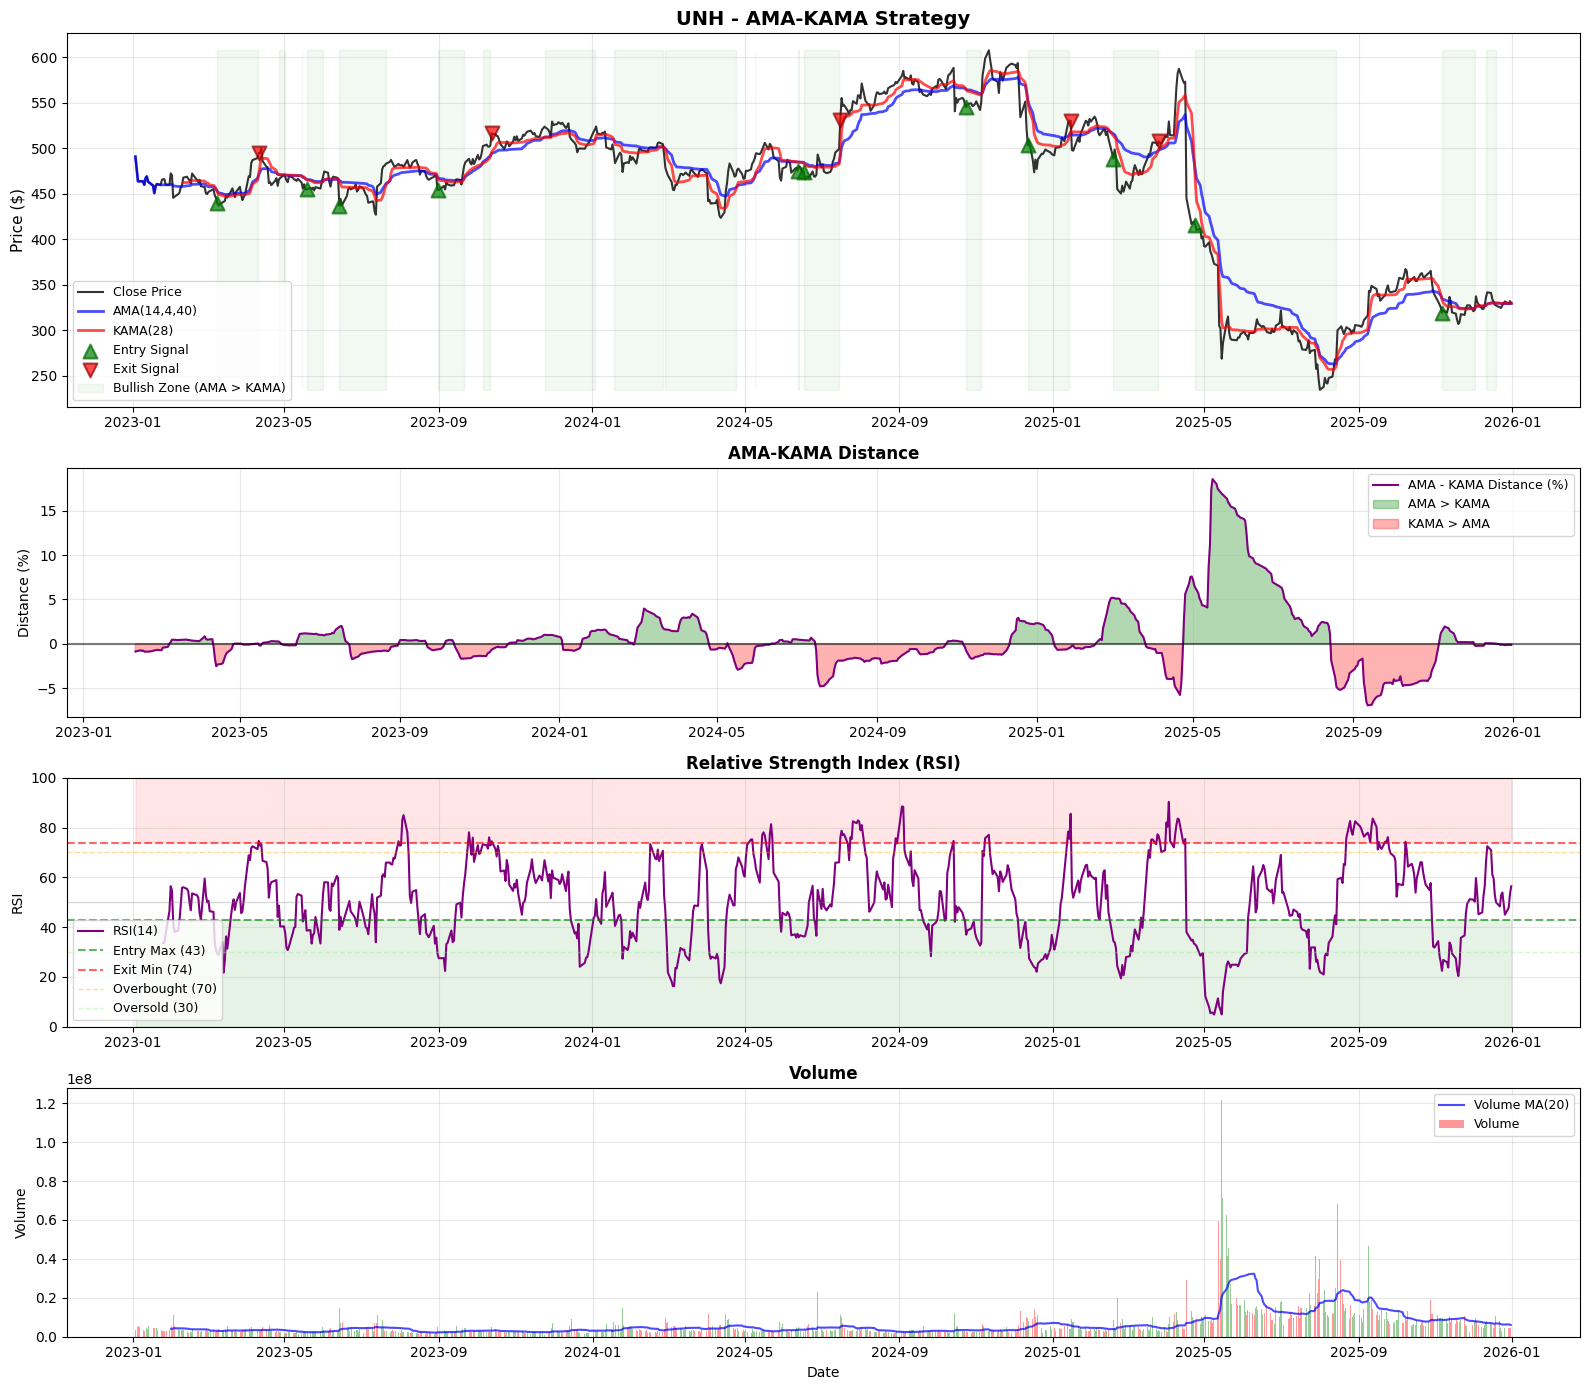

In [25]:

plot_ama_kama_signals(
    data=prepared_data['UNH'],
    ticker='UNH',
    strategy_params=strategy_config.parameters,
    start_date='2023-01-01',
    end_date='2025-12-31', 
)


AMA-KAMA STRATEGY VISUALIZATION FOR GS
Period: 2023-01-01 to 2025-12-31


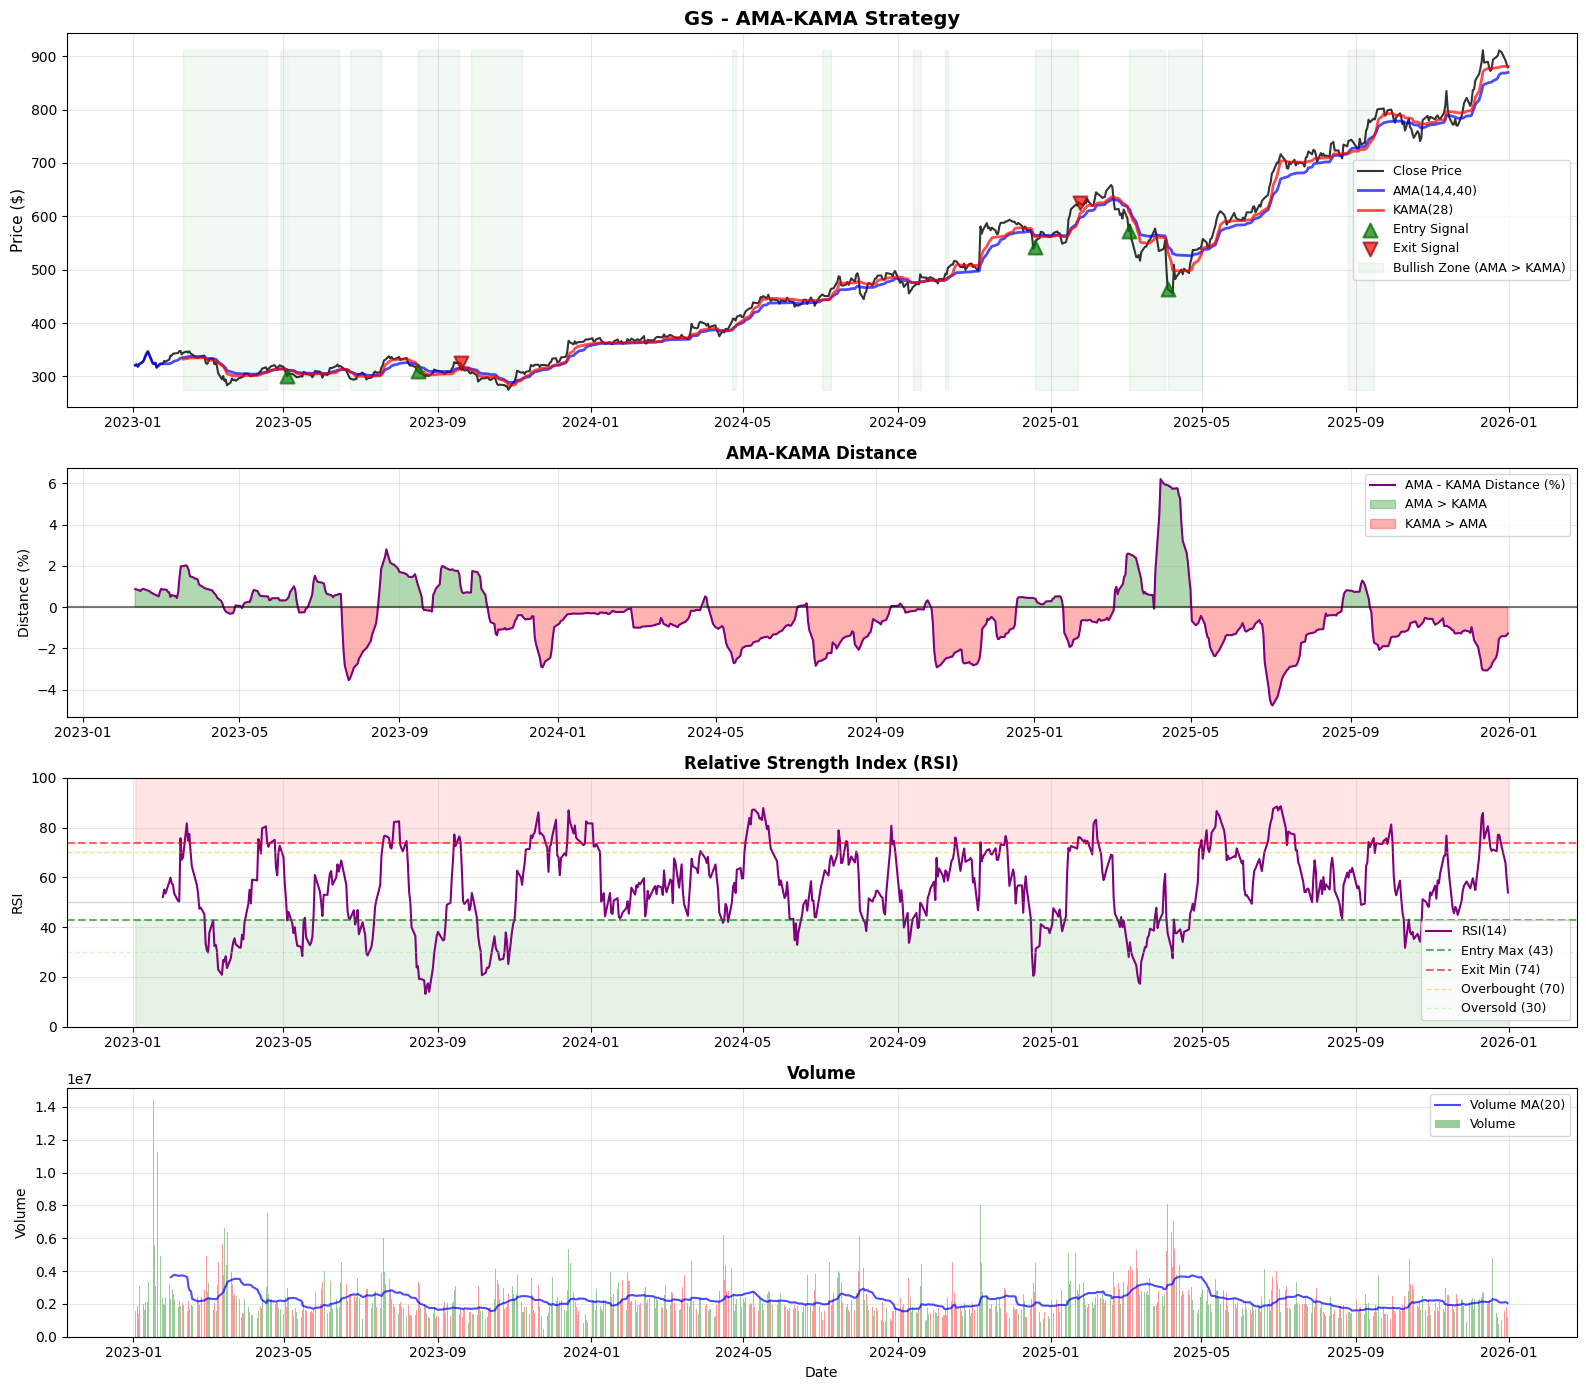


AMA-KAMA STRATEGY VISUALIZATION FOR MSFT
Period: 2023-01-01 to 2025-12-31


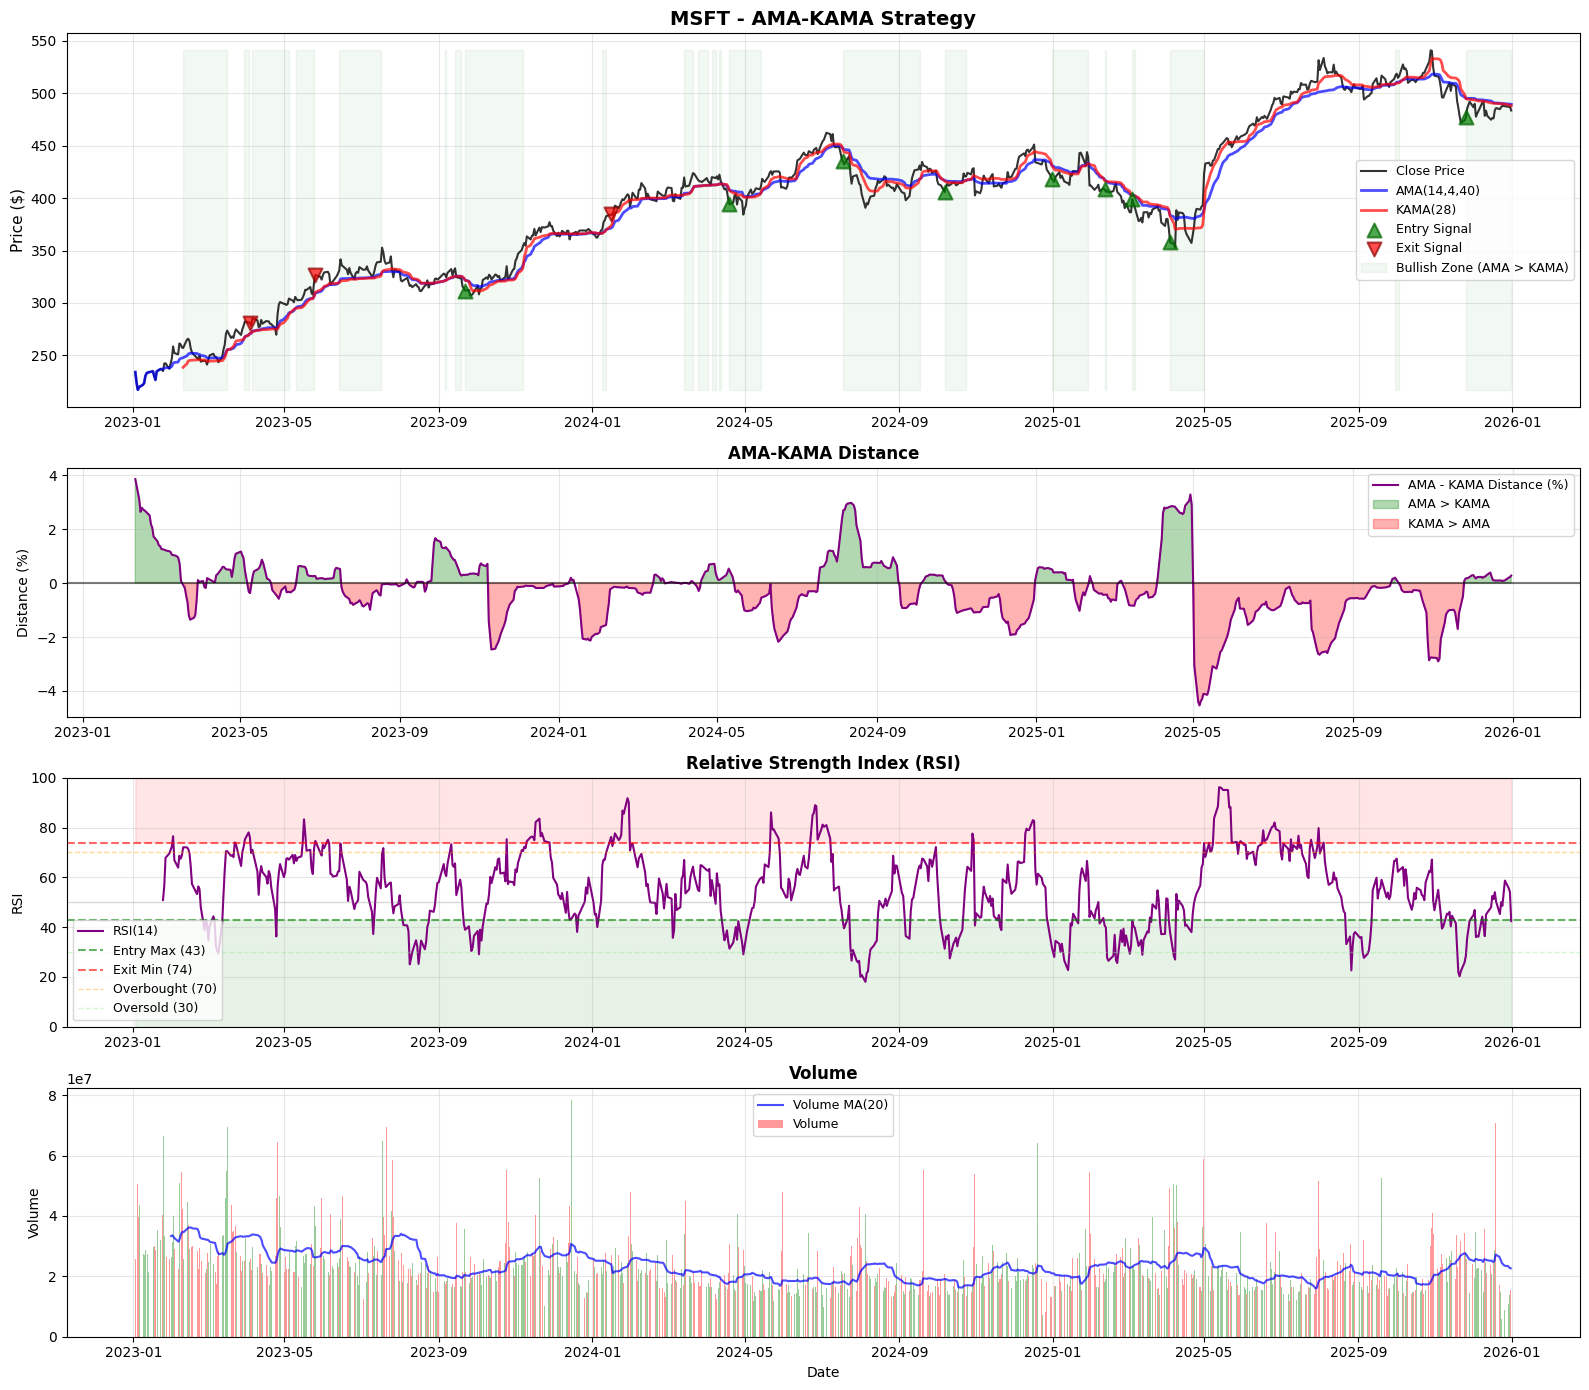


AMA-KAMA STRATEGY VISUALIZATION FOR HD
Period: 2023-01-01 to 2025-12-31


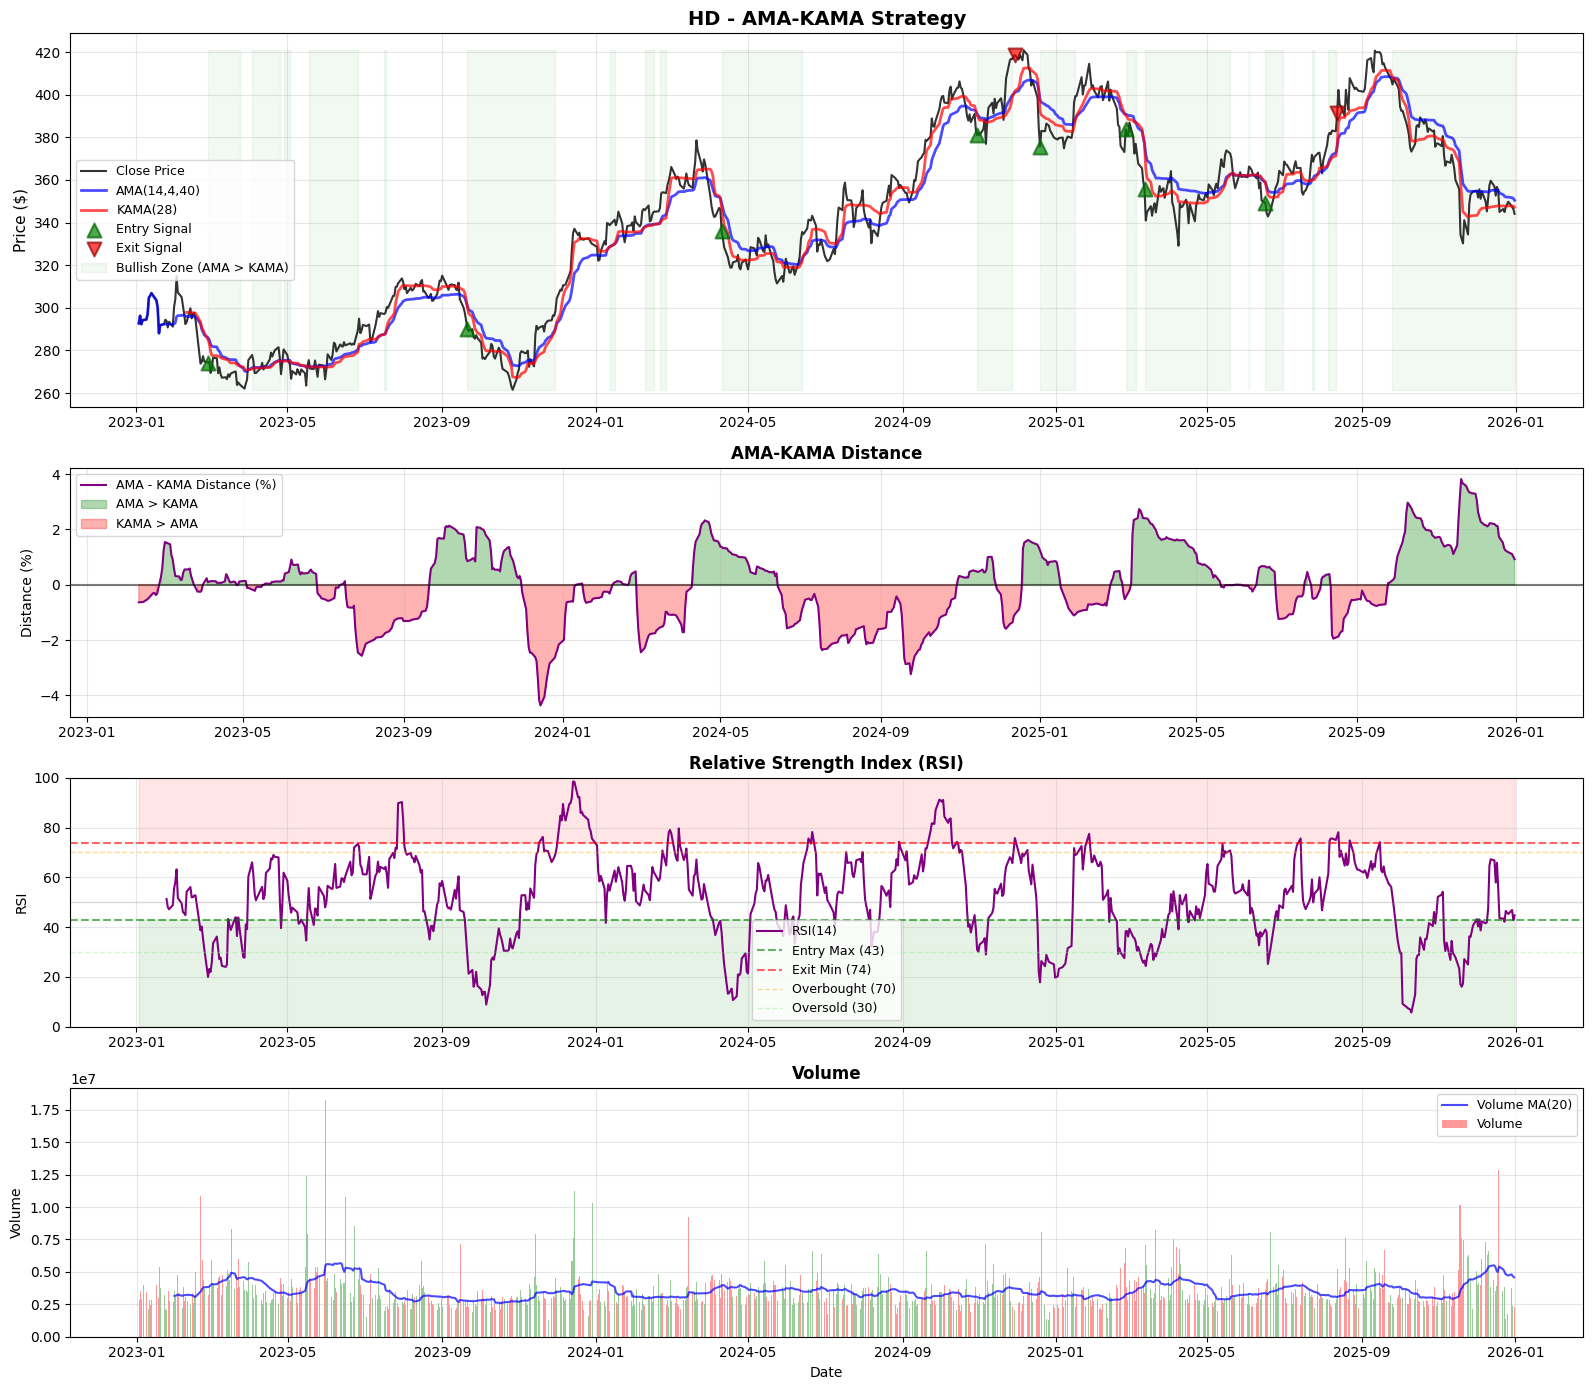


AMA-KAMA STRATEGY VISUALIZATION FOR V
Period: 2023-01-01 to 2025-12-31


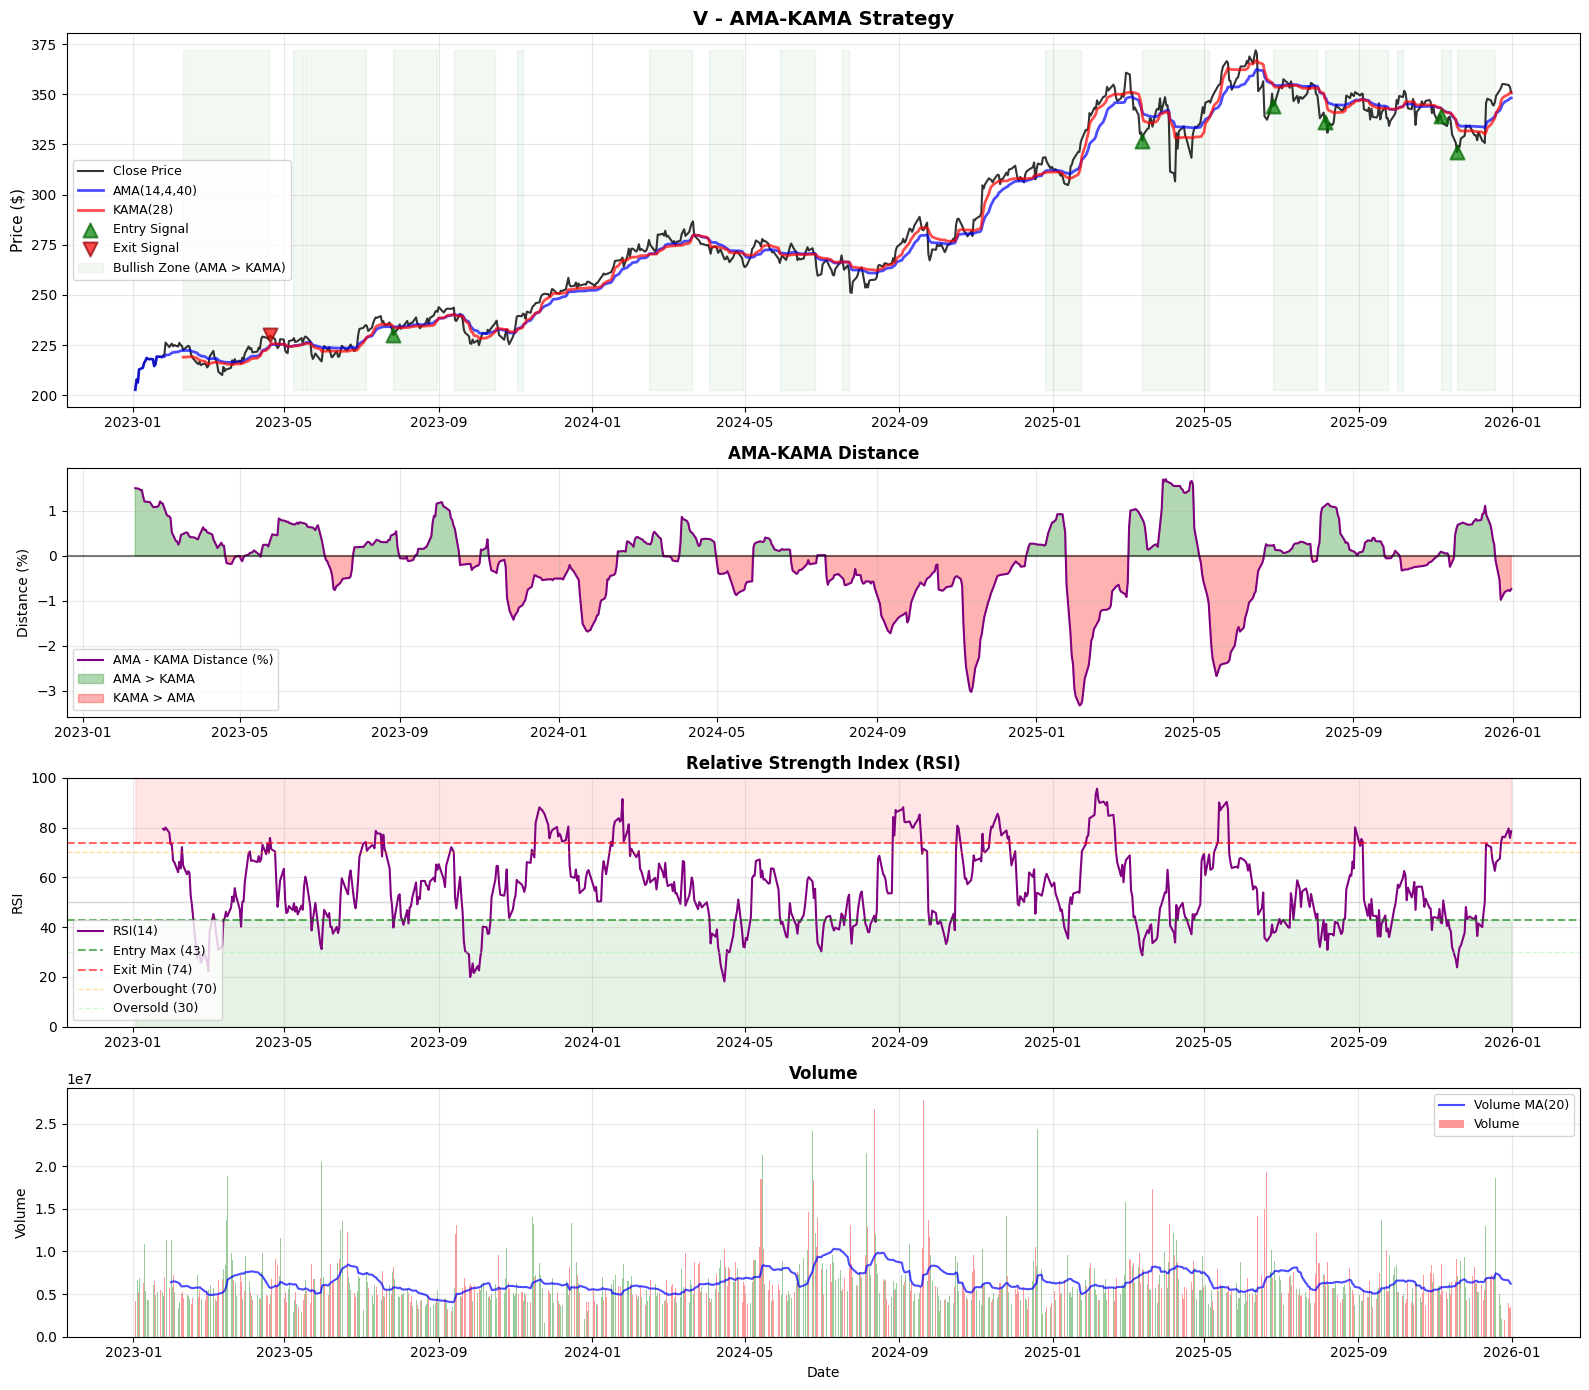


AMA-KAMA STRATEGY VISUALIZATION FOR SHW
Period: 2023-01-01 to 2025-12-31


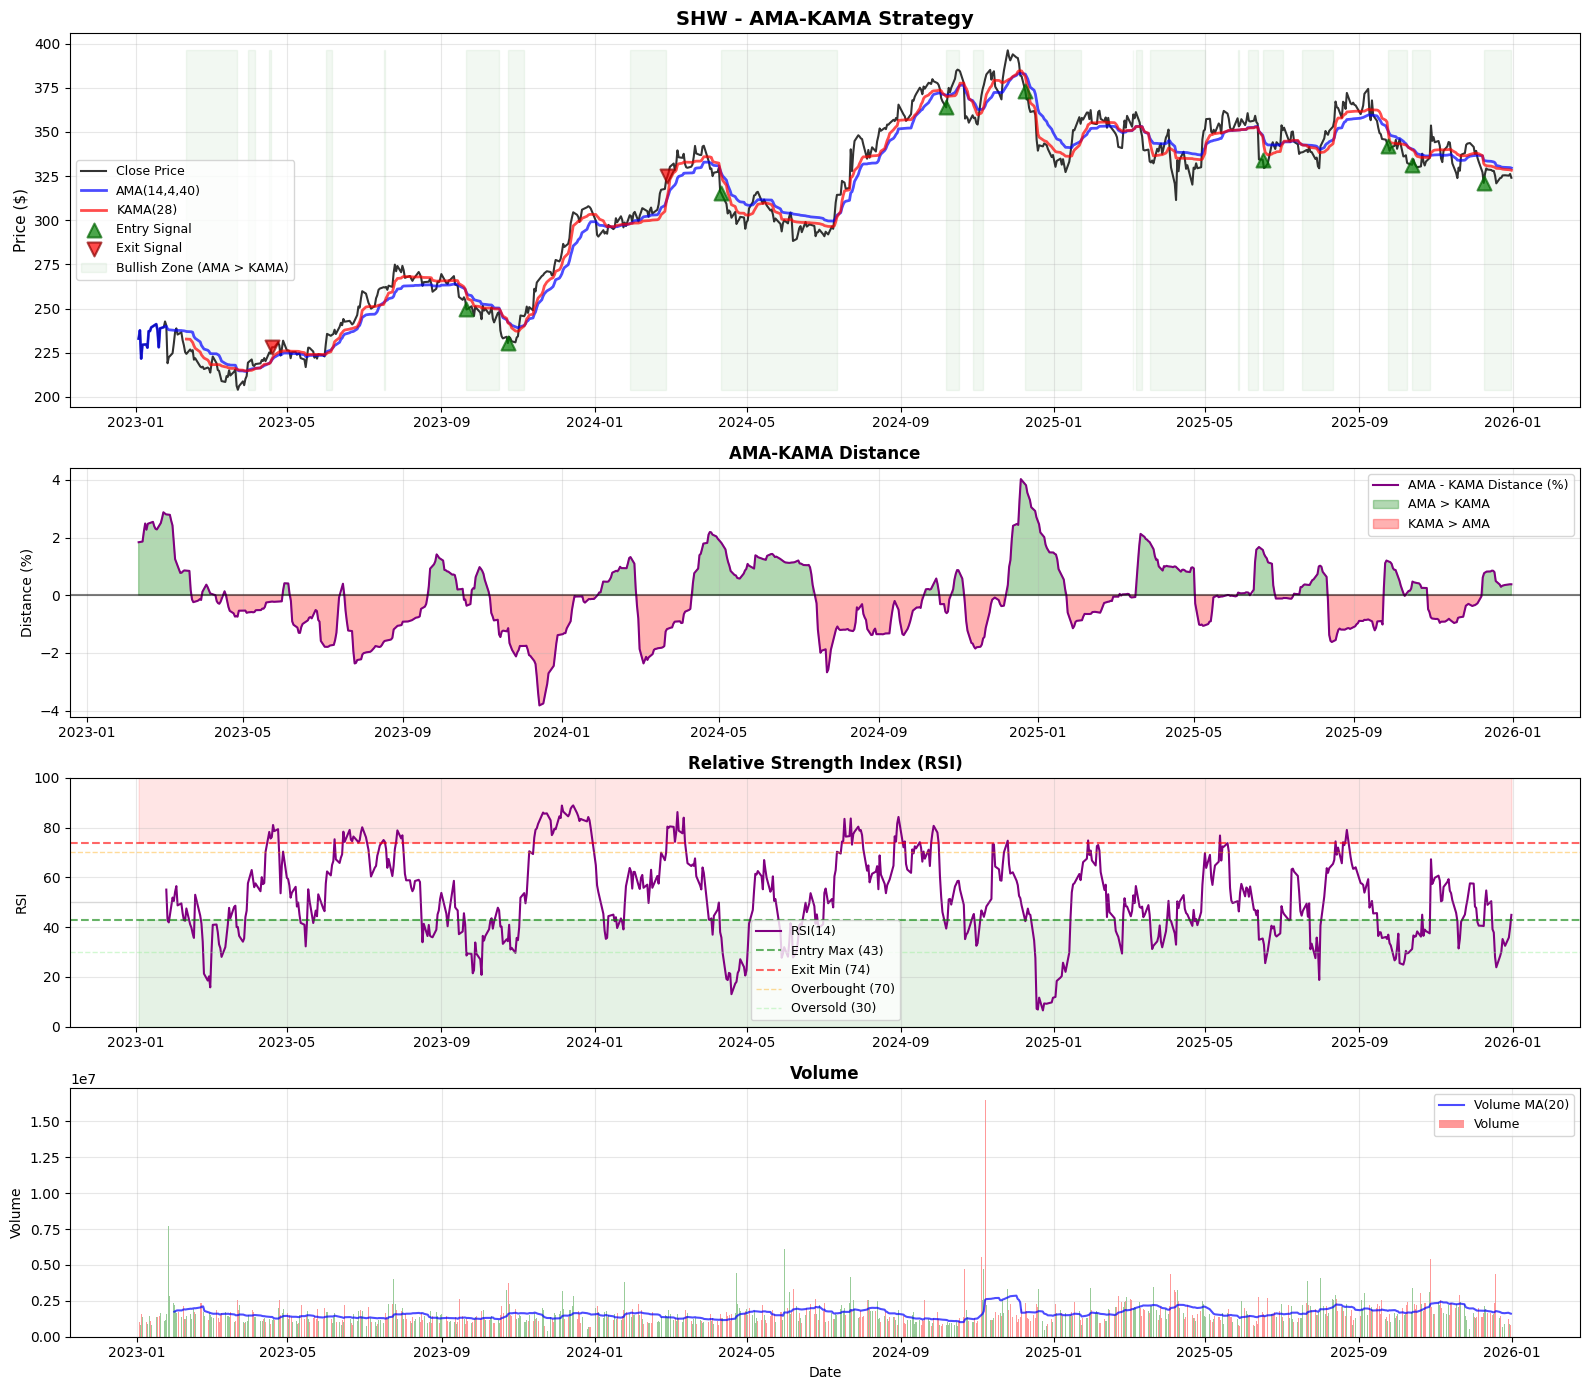


AMA-KAMA STRATEGY VISUALIZATION FOR CAT
Period: 2023-01-01 to 2025-12-31


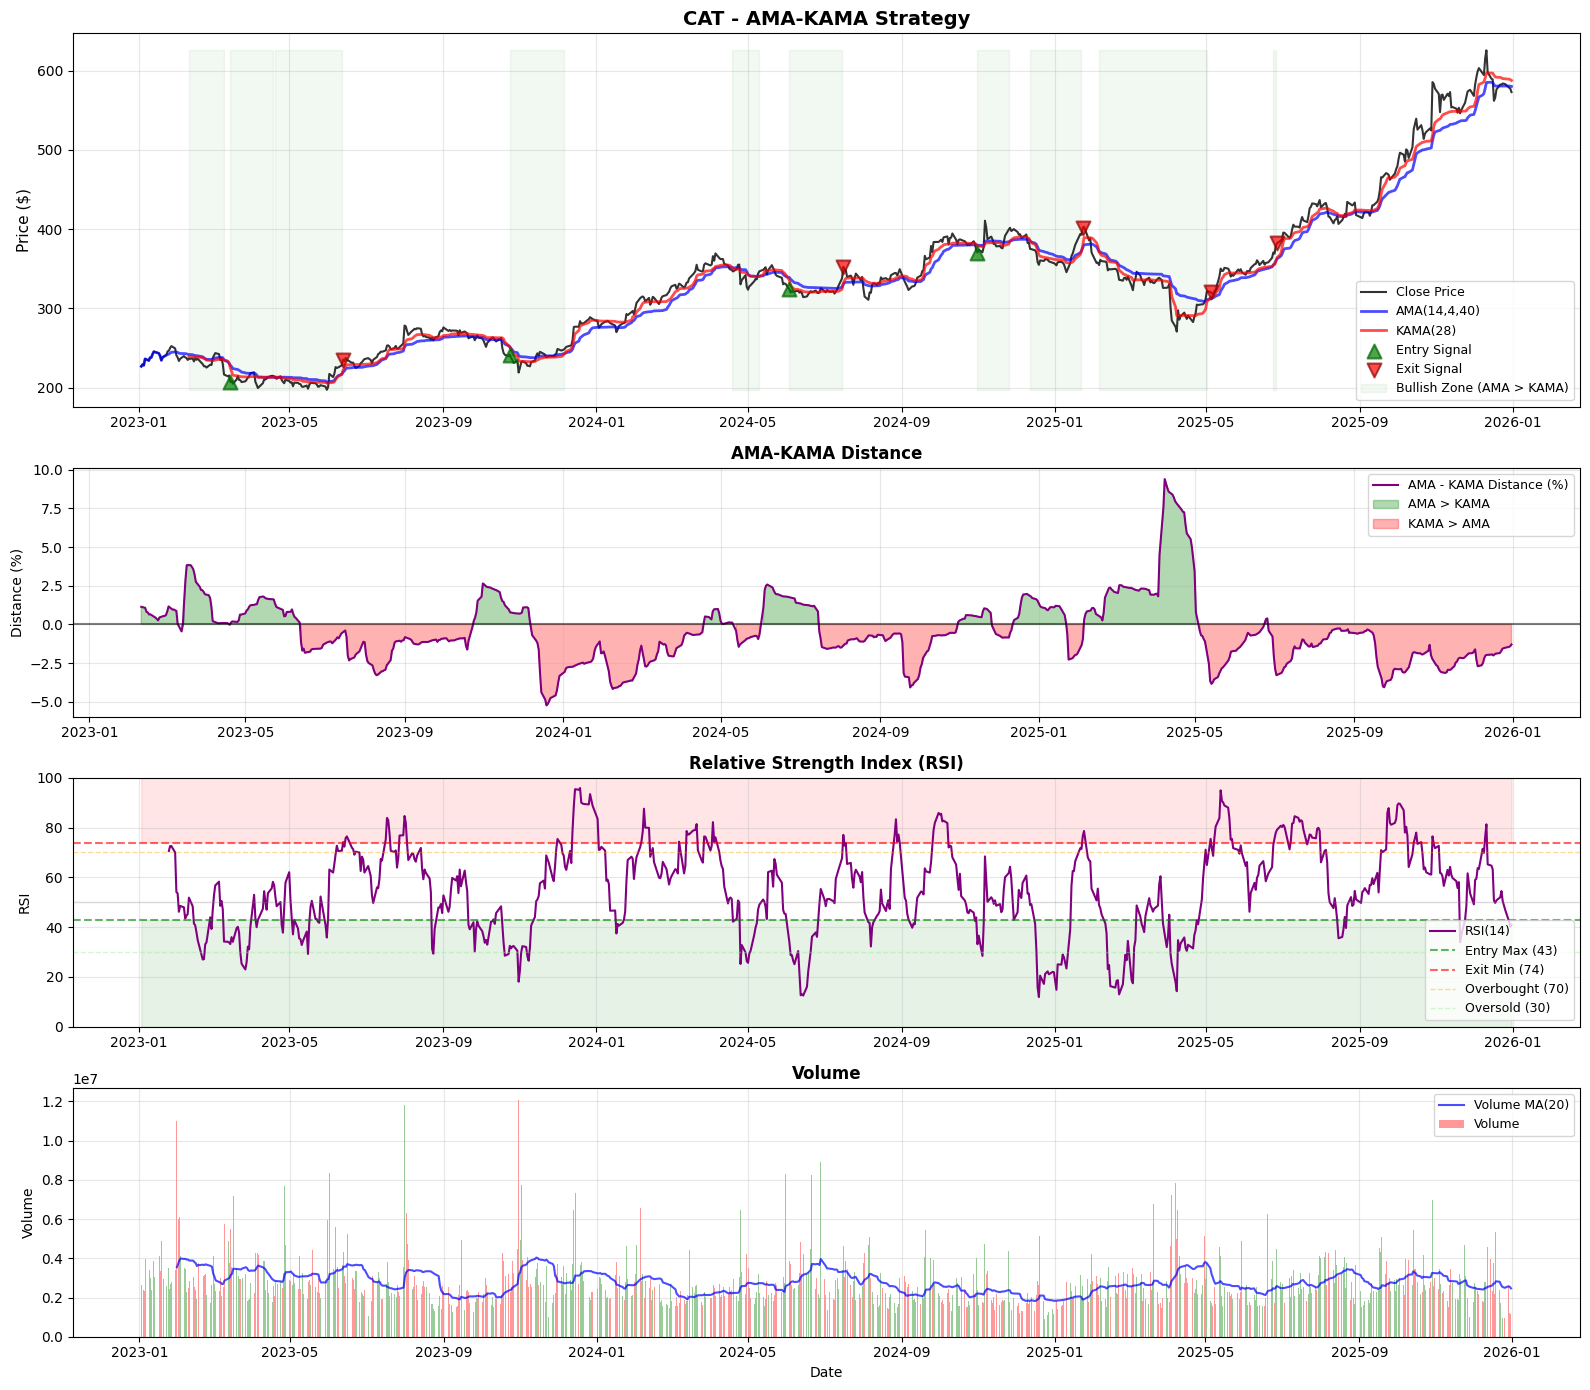


AMA-KAMA STRATEGY VISUALIZATION FOR MCD
Period: 2023-01-01 to 2025-12-31


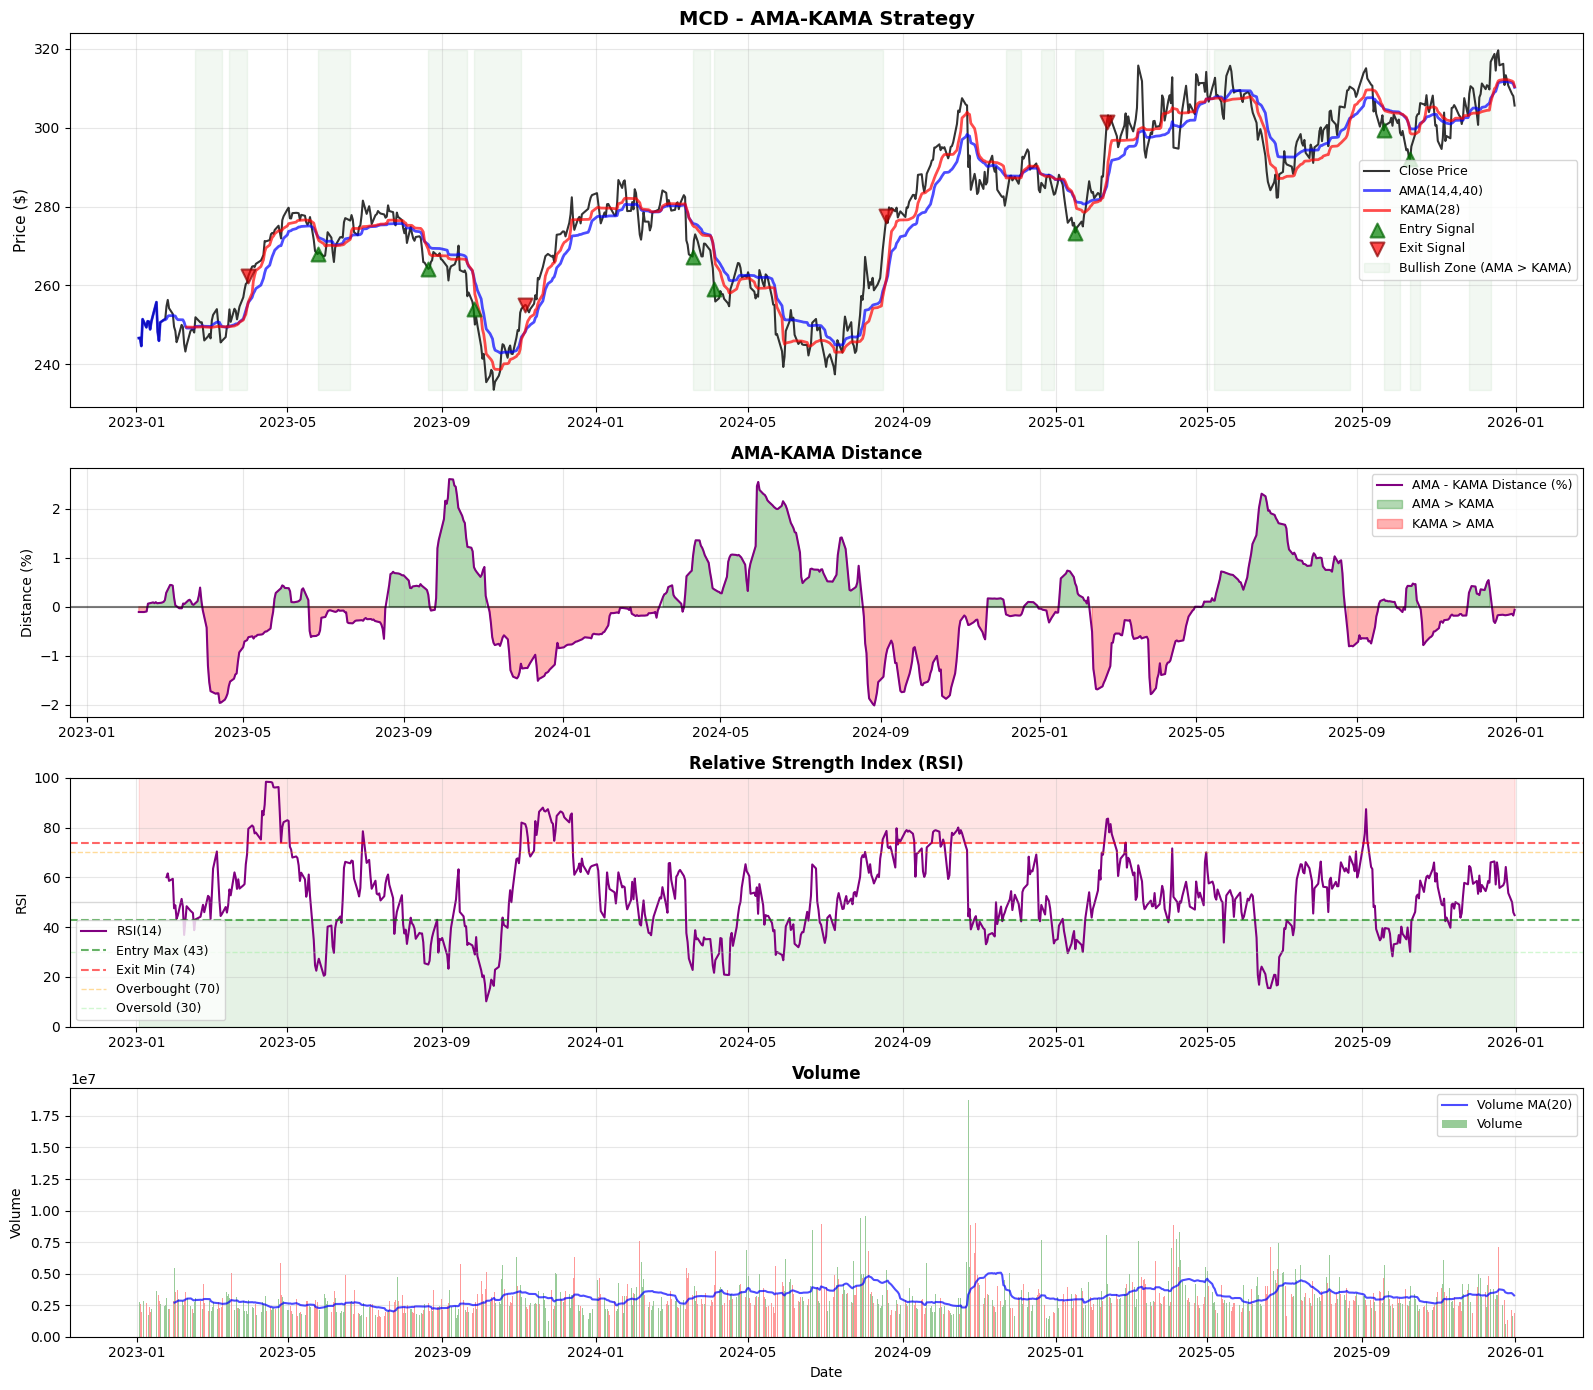


AMA-KAMA STRATEGY VISUALIZATION FOR UNH
Period: 2023-01-01 to 2025-12-31


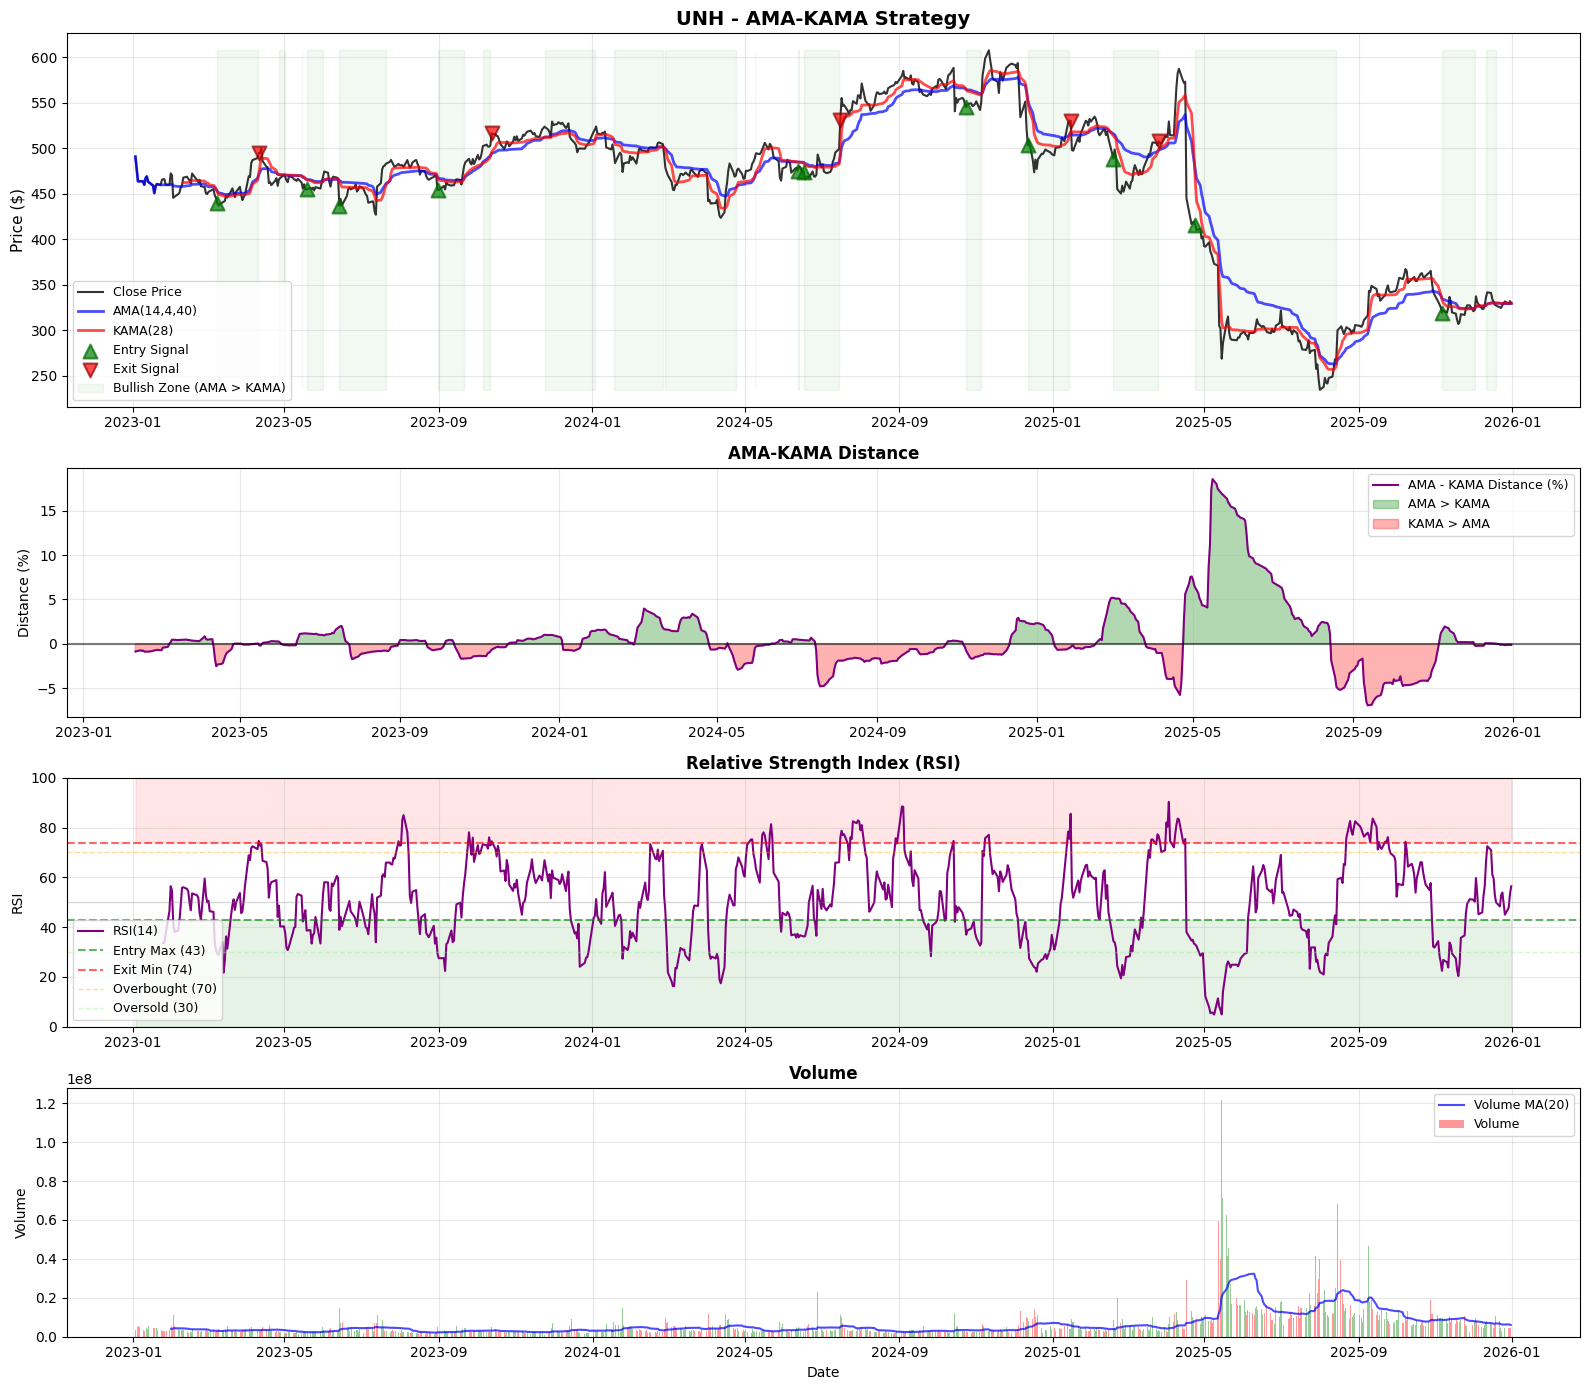


AMA-KAMA STRATEGY VISUALIZATION FOR AXP
Period: 2023-01-01 to 2025-12-31


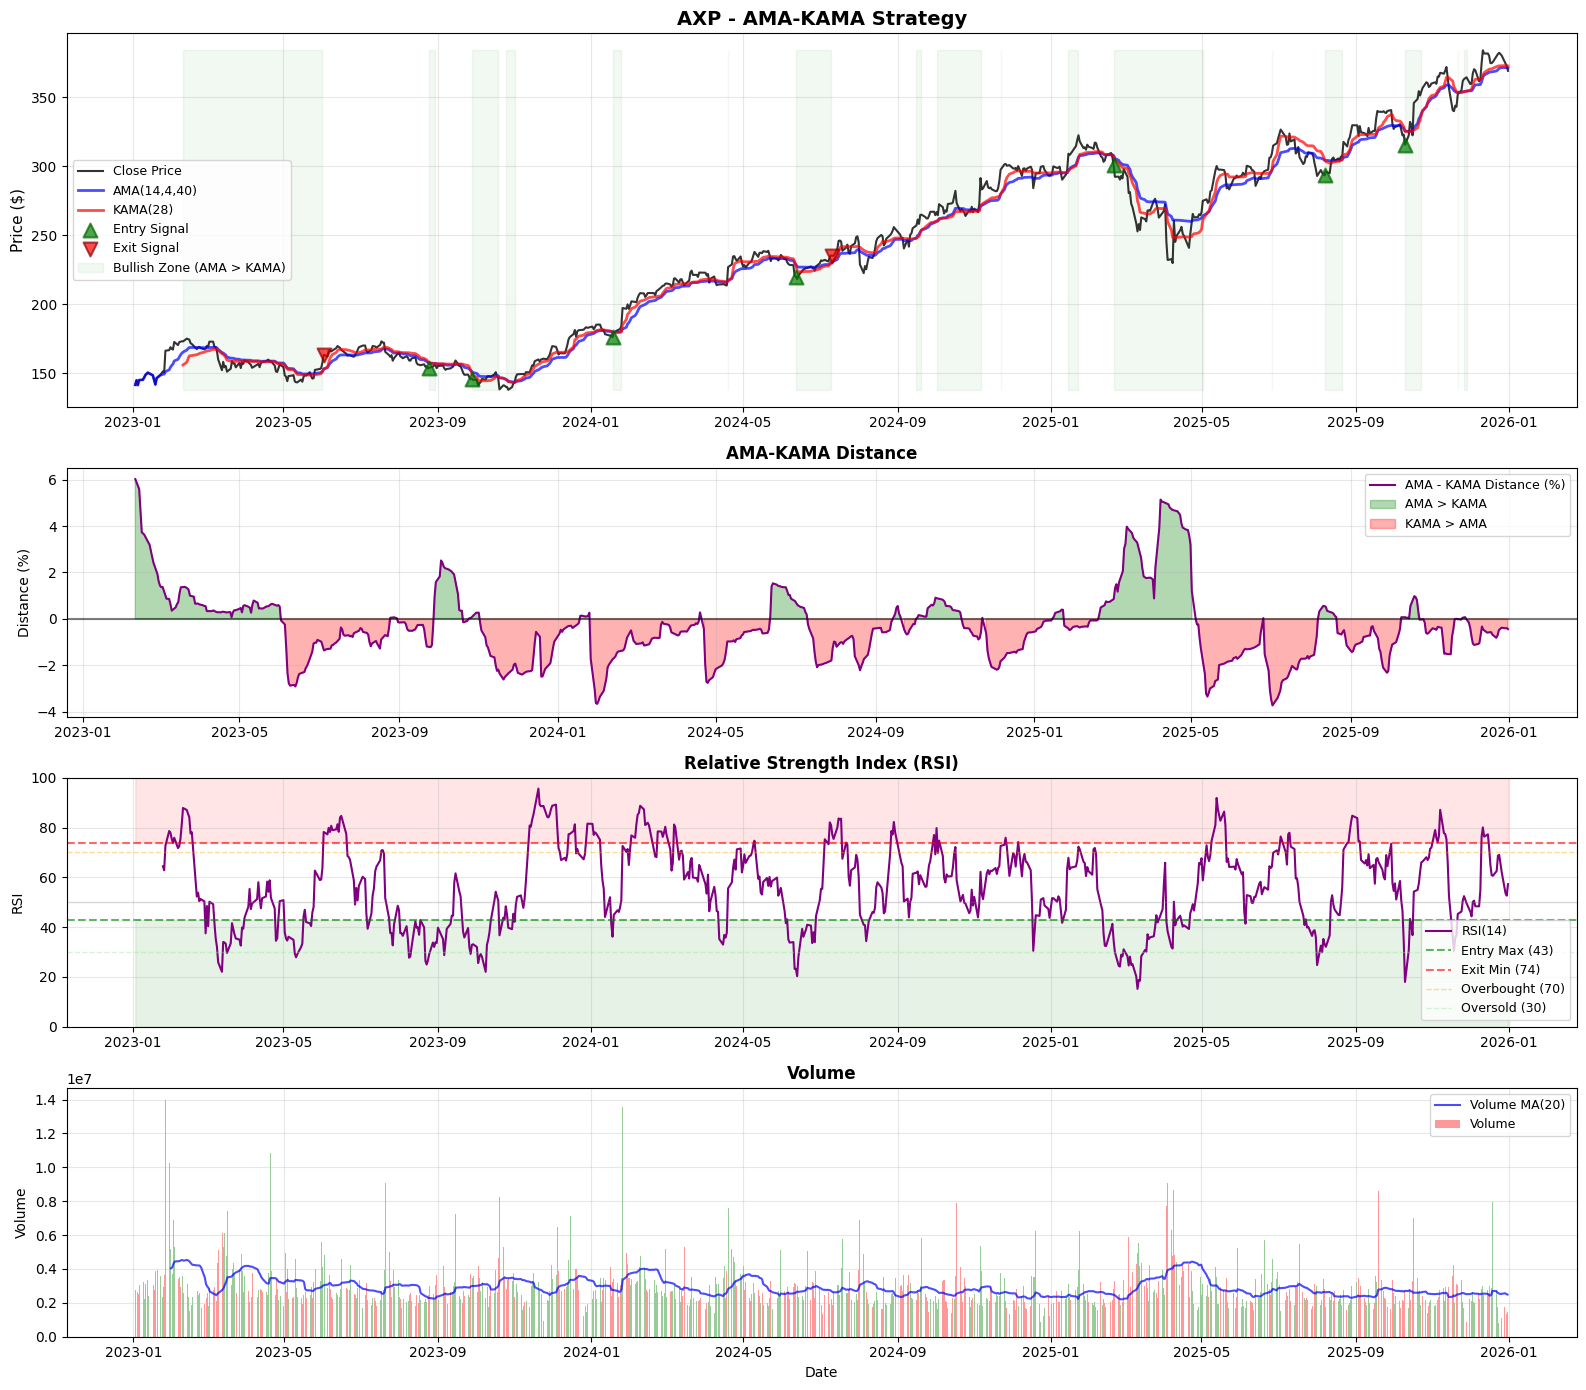

In [26]:
for ticker in prepared_data.keys():

    plot_ama_kama_signals(
        data=prepared_data[ticker],
        ticker=ticker,
        strategy_params=strategy_config.parameters,
        start_date='2023-01-01',
        end_date='2025-12-31', 
    )